In [1]:
import pandas as pd
import numpy as np
import regex as re
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pickle

import matplotlib.pyplot as plt


In [2]:
import seaborn as sns
from sklearn.model_selection import train_test_split


In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# Read data set

In [6]:
file_path = "../DataSet/"
file_name = "exercise_40_train.csv"
df = pd.read_csv(file_path+file_name)

In [7]:
df.shape

(40000, 101)

Check the column names and details as follow.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 101 entries, y to x100
dtypes: float64(86), int64(3), object(12)
memory usage: 30.8+ MB


In [9]:
df.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
0,0,0.165254,18.060003,Wed,1.077380,-1.339233,-1.584341,0.0062%,0.220784,1.816481,...,-0.397427,0.909479,no,5.492487,NaN,10.255579,7.627730,0,yes,104.251338
1,1,2.441471,18.416307,Friday,1.482586,0.920817,-0.759931,0.0064%,1.192441,3.513950,...,0.656651,9.093466,no,3.346429,4.321172,NaN,10.505284,1,yes,101.230645
2,1,4.427278,19.188092,Thursday,0.145652,0.366093,0.709962,-8e-04%,0.952323,0.782974,...,2.059615,0.305170,no,4.456565,NaN,8.754572,7.810979,0,yes,109.345215
3,0,3.925235,19.901257,Tuesday,1.763602,-0.251926,-0.827461,-0.0057%,-0.520756,1.825586,...,0.899392,5.971782,no,4.100022,1.151085,NaN,9.178325,1,yes,103.021970
4,0,2.868802,22.202473,Sunday,3.405119,0.083162,1.381504,0.0109%,-0.732739,2.151990,...,3.003595,1.046096,yes,3.234033,2.074927,9.987006,11.702664,0,yes,92.925935


# Check out data for duplicates


In [10]:
# calculate duplicates
dups = df.duplicated()
# report if there are any duplicates
print(dups.any())
# # list all duplicate rows
# print(df[dups])

False


No duplicates found

In [11]:
df.dtypes.value_counts()

float64    86
object     12
int64       3
dtype: int64

there are 3 types of data in the data set

# Check out the object columns, number of uniques and number of NaNs

In [12]:
columns_obj_dtype = []
for col in df.columns:
    if df[col].dtypes == 'object':
        columns_obj_dtype.append(col)
print('columns_obj_dtype = ', columns_obj_dtype)

print(100*'=')


number_of_Obj_cols_with_nan = 0
columns_obj_dtype_NaN = []


for col in columns_obj_dtype:
    if df[col].isnull().sum() != 0:
        number_of_Obj_cols_with_nan = number_of_Obj_cols_with_nan + 1
        
        columns_obj_dtype_NaN.append(col)
        
        print('number of NaNs in ', col, '=', (df[col].isnull().sum())*100/(df.shape[0]), '%',
              '\nNumber of uniqs =', df[col].nunique(), '\n')
print('number_of_Obj_cols_with_nan ', number_of_Obj_cols_with_nan)

columns_obj_dtype =  ['x3', 'x7', 'x19', 'x24', 'x31', 'x33', 'x39', 'x60', 'x65', 'x77', 'x93', 'x99']
number of NaNs in  x24 = 9.64 % 
Number of uniqs = 2 

number of NaNs in  x33 = 17.9275 % 
Number of uniqs = 51 

number of NaNs in  x77 = 23.1425 % 
Number of uniqs = 7 

number of NaNs in  x99 = 32.09 % 
Number of uniqs = 1 

number_of_Obj_cols_with_nan  4


---
we do have 4 columns containing NaN with obj dtype.

Visualize the columns at the following bar plot.

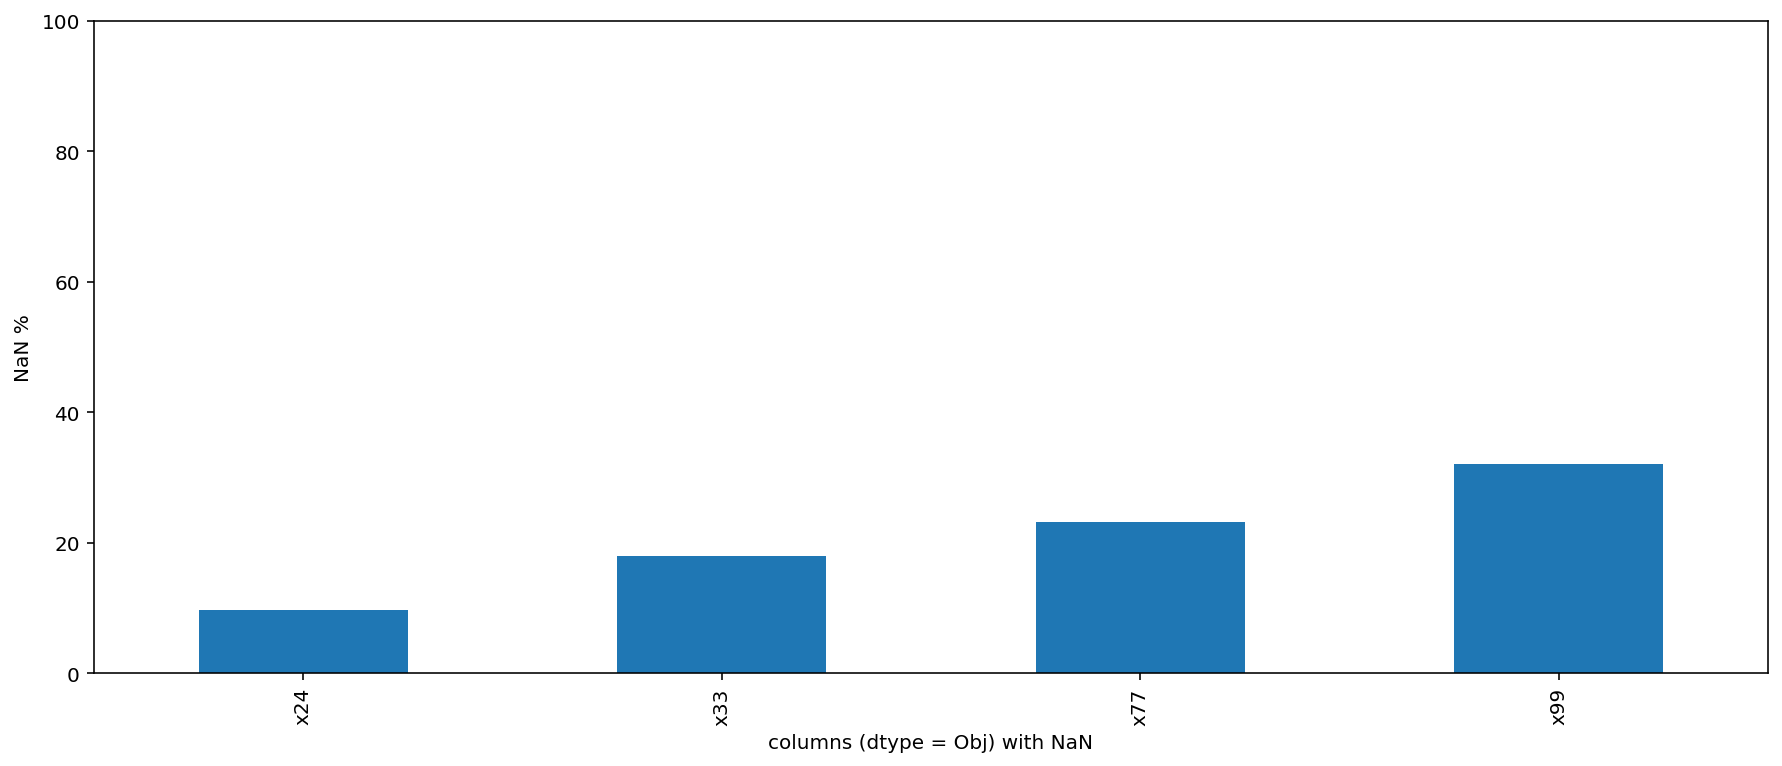

In [13]:
(df[columns_obj_dtype_NaN].isnull().sum()*100/(df.shape[0])).plot(kind='bar',figsize=(15,6))
plt.xlabel('columns (dtype = Obj) with NaN')
plt.ylabel('NaN %')
plt.ylim(0,100)
plt.show()

In [14]:
df[columns_obj_dtype].nunique()

x3        14
x7       663
x19    40000
x24        2
x31        2
x33       51
x39        1
x60       12
x65        5
x77        7
x93        2
x99        1
dtype: int64

# Checking out categorical columns one by one and make sure about values and types and etc

check out the 'x3' column

In [15]:
df['x3'].unique()

array(['Wed', 'Friday', 'Thursday', 'Tuesday', 'Sunday', 'Saturday',
       'Sat', 'Wednesday', 'Sun', 'Tue', 'Thur', 'Monday', 'Fri', 'Mon'],
      dtype=object)

## x3 is nominal categorical feature (needs OneHotEncoder transformer)

check out the 'x7' column

In [16]:
df['x7'].unique()

array(['0.0062%', '0.0064%', '-8e-04%', '-0.0057%', '0.0109%', '0.0079%',
       '0.0174%', '-0.0106%', '0.0032%', '0.0091%', '-0.0052%',
       '-0.0025%', '-0.0045%', '0.0068%', '-0.0137%', '-0.0014%',
       '-0.0013%', '0.0066%', '0.0097%', '-0.0086%', '0.0023%',
       '-0.0023%', '-0.0107%', '-0.0134%', '0.0058%', '-2e-04%',
       '-0.0033%', '-0.0172%', '-0.0026%', '-0.0118%', '0.0105%',
       '-0.0055%', '0.0095%', '0.0026%', '-0.0051%', '0.0054%',
       '-0.0167%', '0.0015%', '-0.0037%', '0.0011%', '-0.0097%',
       '-0.0016%', '-0.0155%', '0.015%', '-0.0032%', '2e-04%', '0.0122%',
       '0.0082%', '-0.0054%', '-0.0017%', '0.0013%', '0.0025%',
       '-0.0021%', '-0.017%', '-0.005%', '0.0014%', '-0.0103%', '-0.018%',
       '-0.0077%', '-0.0115%', '-0.0018%', '6e-04%', '-0.0169%',
       '0.0051%', '0.0093%', '-0.0043%', '0.0157%', '-0.0012%', '0.0056%',
       '-0.0035%', '0.005%', '0.0073%', '0.0127%', '0.0098%', '-0.0022%',
       '-0.0146%', '-0.0168%', '0.001%', '-0.

## x7 column: the % sign should be cleaned from strings and I need to change the dtype and introduce it as numeric feature.

In [17]:
df['x7'] = df['x7'].str.replace('%','')

In [18]:
df['x7'].dtypes

dtype('O')

In [19]:
df['x7'] = df['x7'].astype('float64')

In [20]:
df['x7'].dtypes

dtype('float64')

check out the 'x19' column

In [21]:
df['x19']

0        $-908.650758424405
1         $-1864.9622875143
2        $-543.187402955527
3        $-182.626380634258
4         $967.007090837503
                ...        
39995     $3750.51991954505
39996     $448.867118077561
39997      $834.95775080472
39998    $-48.1031003332715
39999     $96.0017151741518
Name: x19, Length: 40000, dtype: object

## x19 column: the % sign should be cleaned from strings and I need to change the dtype and introduce it as numeric feature.

In [22]:
df['x19'] = df['x19'].str.replace('$','')

In [23]:
df['x19'].dtypes

dtype('O')

In [24]:
df['x19'] = df['x19'].astype('float64')

In [25]:
df['x19'].dtypes

dtype('float64')

check out the 'x24' column

In [26]:
df['x24']

0        female
1          male
2          male
3          male
4          male
          ...  
39995    female
39996      male
39997      male
39998      male
39999       NaN
Name: x24, Length: 40000, dtype: object

## x24 column: is nominal category and needs to be transformed using One Hot Encoding

check out the x31 column

In [27]:
df['x31']

0         no
1         no
2         no
3         no
4        yes
        ... 
39995     no
39996    yes
39997    yes
39998     no
39999     no
Name: x31, Length: 40000, dtype: object

## x31 column: is nominal category and needs to be transformed using One Hot Encoding

check out the x33 column

In [28]:
df['x33']

0         Colorado
1        Tennessee
2            Texas
3        Minnesota
4         New York
           ...    
39995          NaN
39996     Illinois
39997          NaN
39998         Ohio
39999      Florida
Name: x33, Length: 40000, dtype: object

## x33 column: is nominal category and needs to be transformed using One Hot Encoding

check out the x39 column

In [29]:
df['x39']

0        5-10 miles
1        5-10 miles
2        5-10 miles
3        5-10 miles
4        5-10 miles
            ...    
39995    5-10 miles
39996    5-10 miles
39997    5-10 miles
39998    5-10 miles
39999    5-10 miles
Name: x39, Length: 40000, dtype: object

## Drop the column x39

check out the x60 column

In [30]:
df['x60']

0           August
1            April
2        September
3        September
4          January
           ...    
39995         July
39996         July
39997       August
39998     December
39999      January
Name: x60, Length: 40000, dtype: object

## x60 is nominal and OneHotEncoder should be used to transfer this column

check out the x65 column

In [31]:
df['x65']

0            farmers
1           allstate
2              geico
3              geico
4              geico
            ...     
39995        farmers
39996    progressive
39997          geico
39998        farmers
39999    progressive
Name: x65, Length: 40000, dtype: object

## x65 is nominal and OneHotEncoder should be used to transfer this column

check out the x77 column

In [32]:
df['x77']

0        mercedes
1        mercedes
2          subaru
3          nissan
4          toyota
           ...   
39995         NaN
39996        ford
39997        ford
39998         NaN
39999      toyota
Name: x77, Length: 40000, dtype: object

## x77 is nominal and OneHotEncoder should be used to transfer this column


check out the x93 column

In [33]:
df['x93']

0         no
1         no
2         no
3         no
4        yes
        ... 
39995     no
39996     no
39997     no
39998     no
39999     no
Name: x93, Length: 40000, dtype: object

## x93 is nominal and OneHotEncoder should be used to transfer this column


check out the x99 (it has just one value - it is usedful)

In [34]:
df['x99']

0        yes
1        yes
2        yes
3        yes
4        yes
        ... 
39995    yes
39996    yes
39997    yes
39998    yes
39999    NaN
Name: x99, Length: 40000, dtype: object

## X99 should be droped - it has just one category. The x24, x33, and x77 columns NaN values needs to be replaced by their mode.


# Recap for categorical columns

* x3 is nominal categorical feature (needs OneHotEncoder transformer)
* x7 column: the % sign should be cleaned from strings and I need to change the dtype and introduce it as numeric feature.
* x19 column: the % sign should be cleaned from strings and I need to change the dtype and introduce it as numeric feature.
* x24 column: is nominal category and needs to be transformed using One Hot Encoding
* x31 column: is nominal category and needs to be transformed using One Hot Encoding
* x33 column: is nominal category and needs to be transformed using One Hot Encoding
* x39 should be droped the column 
* x60 is nominal and OneHotEncoder should be used to transfer this column
* x65 is nominal and OneHotEncoder should be used to transfer this column
* x77 is nominal and OneHotEncoder should be used to transfer this column
* x93 is nominal and OneHotEncoder should be used to transfer this column
* X99 should be droped - it has just one category. 
* The x24, x33, and x77 columns NaN values needs to be replaced by their mode.


In [35]:
dasfaa

NameError: name 'dasfaa' is not defined

In [ ]:
# column_trans = make_column_transformer(
#     (OneHotEncoder(), ['Sex', 'Embarked']),
#     remainder='passthrough')
# logreg = LogisticRegression(solver='lbfgs')


# pipe = make_pipeline(column_trans, logreg)


# cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()


# X_new = X.sample(5, random_state=99)
# pipe.fit(X, y)
# pipe.predict(X_new)

# Dealing with NaNs in numerical columns NaN

Check out the numerics columns, number of uniques and number of NaNs

In [ ]:
columns_numeric_dtype = []
for col in df.columns:
    if df[col].dtypes == 'float64' or df[col].dtypes == 'int64':
        columns_numeric_dtype.append(col)
print('columns_numeric_dtype = ', columns_numeric_dtype)

print(100*'=')

# check the object columns uniqueness

number_of_numeric_cols_with_nan = 0

columns_numeric_dtype_NaN = []
for col in columns_numeric_dtype:
    if df[col].isnull().sum() != 0:
        number_of_numeric_cols_with_nan = number_of_numeric_cols_with_nan+1
        columns_numeric_dtype_NaN.append(col)
        print('number of NaNs in', col, '=', df[col].isnull().sum()*100/(df.shape[0]), '%')#, 'var = ', df[col].var())
        
print('\nnumber_of_numeric_cols_with_nan ', number_of_numeric_cols_with_nan)

Let's calculate the average number of NaNs in numeric columns containing NaN 

In [ ]:
average_percentage_NaN = (df[columns_numeric_dtype_NaN].isnull().sum().sum()*100/\
                          (df.shape[0]))/len(columns_numeric_dtype_NaN)
average_percentage_NaN = round(average_percentage_NaN,1)
print(f'average_percentage_NaN {average_percentage_NaN} %')

In [ ]:
(df[columns_numeric_dtype_NaN].isnull().sum()*100/(df.shape[0])).plot(kind='bar',figsize=(15,6), label='NaN %')


plt.hlines(average_percentage_NaN,0,38, 
           linestyles='--',colors='r', label='Average % of NaN in all columns')

plt.xlabel('columns (dtype = numeric) with NaN')
plt.ylabel('NaN %')
plt.legend()
plt.show()

Drop columns with NaN% greater than total average (red dashed line).

In [ ]:
columns_to_drop_numer = []
for col in columns_numeric_dtype_NaN:
    if (df[col].isnull().sum()*100/(df.shape[0])) > average_percentage_NaN:
        columns_to_drop_numer.append(col)
    
print('numeric columns to be droped are\n', columns_to_drop_numer)

In [ ]:
df_nan_droped = df.drop(df[columns_to_drop_numer], axis=1)

In [ ]:
print(df_nan_droped.shape)

Relpace the NaN in the numeric columns with mean

In [ ]:
df_nan_droped.info()

In [ ]:
(df[columns_numeric_dtype_NaN].var()).plot(kind='bar',figsize=(15,6), log=True)
plt.xlabel('columns (dtype = numeric) with NaN')
plt.ylabel('NaN %')
plt.show()

# checking out the features variances and drop them based on the column variances.

In [ ]:
# define thresholds to check
thresholds = np.arange(0.0, 1000, 100)
# apply transform with each threshold
results = list()
for t in thresholds:
    # define the transform
    transform = VarianceThreshold(threshold=t)
    # transform the input data
    X_sel = transform.fit_transform(X_train_trans_df)
    # determine the number of input features
    n_features = X_sel.shape[1]
    print('>Threshold=%.2f, Features=%d' % (t, n_features))
    # store the result
    results.append(n_features)
# plot the threshold vs the number of selected features
plt.plot(thresholds, results, 'ro-')
plt.xlabel('VarianceThreshold')
plt.ylabel('Number of features')
plt.ylim(0,5)
plt.savefig('../Figures/Supervise_Sub_Project_f1.png')
plt.show()

In [ ]:
df_corr[['y']].sort_values(by=['y'], ascending=False).plot(kind='barh')
plt.show()

In [ ]:
# df_corr = df.corr().abs()

# #plt.figure(figsize=(6,6))
# plt.figure(figsize=(6,40))
# sns.heatmap(df_corr[['y']].sort_values(by=['y'],ascending=False),
# #             vmin=0,
#             cmap='Blues',
#             annot=True);
# # plt.savefig("../Figures/" + section_fig_main_title +"plt1_corr_1.png")
# plt.show()

# Check out the dtypes in data frame

## Check out columns unique values percentage


In [ ]:
uniq_index = list(df.nunique().index)
uniq_values = list(df.nunique())
num_rows = df.shape[0]

uniq_percent = [(val*100)/num_rows for val in uniq_values]
for i, uniq in enumerate(uniq_percent):
    print(uniq_index[i])
    print(round(uniq, 4))

keep object columns names and count the number of null values

In [ ]:
# df[columns_obj_dtype].isnull().sum()

In [ ]:
# df[df['x24'].isnull()]

Drop object columns with null values. 

I keep the column names that I wannt to keep (with no null values).

In [ ]:
dtype_obj_cols_to_keep = []
for col in columns_obj_dtype:
    if df[col].isnull().sum() == 0:
        dtype_obj_cols_to_keep.append(col)
print('dtype_obj_cols_to_keep = ', dtype_obj_cols_to_keep)

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(df.isnull().sum())
plt.ylim(0, df.shape[0])
plt.show()

## Keep columns that have less than 50% nulls

In [ ]:
df.shape

In [ ]:
cnt = 0
keep_cols = []
for col in df.columns:
    if df[col].isnull().sum() < 0.5*(df.shape[0]):
        cnt = cnt + 1
        keep_cols.append(col)
#         print(col)

print('number of columns to keep =',cnt)

In [ ]:
df_keep_cols = df[keep_cols]
df_keep_cols.shape

In [ ]:
cnt = 0
for col in df_keep_cols.columns:
    if df_keep_cols[col].isnull().sum() > 0:
        cnt = cnt + 1

print('number of columns with null values =', cnt)

In [ ]:
# Replace the missed values with mean 

column_means = df_keep_cols.mean()
df_keep_cols_fillna_mean = df_keep_cols.fillna(column_means)

In [ ]:
df_keep_cols.head()

In [ ]:
df_keep_cols_fillna_mean.isnull().sum()

In [ ]:
cnt = 0
for col in df_keep_cols_fillna_mean.columns:
    if df_keep_cols_fillna_mean[col].isnull().sum() > 0:
        cnt = cnt + 1

print('number of columns with null values =',cnt)